# Modeling Demand for Cars with the Multinomial Logit Model

In this notebook, we will explore the dataset used in
Brownstone and Train (1999). We will estimate the Multinomial Logit Model
model given the available data using the functions defined below.


In [1]:
import numpy as np
import pandas as pd 
import os
from numpy import linalg as la
from scipy import optimize
from scipy.stats import t
from IPython import display
from matplotlib import pyplot as plt
import itertools as iter

Data
====

The data consists of a survey of households regarding their preferences
for car purchase. Each household was given 6 options, but the
characteristics that the respondents were asked about was varied. The
surveys were originally conducted in order to illicit consumer
preferences for alternative-fuel vehicles. The data is *stated
preferences*, in the sense that consumers did not actually buy but just
stated what they would hypothetically choose, which is of course a
drawback. This is very common in marketing when historic data is either
not available or does not provide satisfactory variation. The advantage
of the stated preference data is therefore that the choice set can be
varied greatly (for example, the characteristics includes the
availability of recharging stations, which is important for purchase of
electric cars).

The data has $N=4654$ respondents with $J=6$ cars to choose
from.

Loading the dataset, `car_data.csv`, we get a dataframe with 
$NJ = 27,924$ rows. The column `person_id` runs through $0,1,...,N-1$, and
the column `j` is the index for the car, $\{0,1,...,5\}$. The variable 
`binary_choice` is a dummy, =1 for the car chosen by the respondent. 
A conveneint other variable, `y`, is the index for that car, repeated 
and identical for all $J$ rows for each person. The x-variables describe 
the characteristics of the 6 cars that the respondent was asked to choose 
from. 

We also read in the dataset `car_labels.csv`, which contains the 
variable labels and descriptions for all the variables. 
The lists `x_vars` and `x_lab` will be used throughout as the list of 
explanatory variables we want to work with. 

In order to get the data into a 3-dimensional array, we access 
the underlying numpy arrays and resize them. For example 

> `x = dat[x_vars].values.resize((N,J,K))`

Note that this will only work because the data is sorted according to 
first `person_id` and then `j`. You can test this by verifying that 
`x[0,:,k]` prints the same as `dat.loc[dat.person_id == 0, x_vars[k]]`. 

In [2]:
# Load dataset and variable names
os.chdir('../GREENCAR_notebooks/')
input_path = os.getcwd() # Assigns input path as current working directory (cwd)
dat = pd.read_csv(os.path.join(input_path, 'car_data.csv'))
lab = pd.read_csv(os.path.join(input_path, 'car_labels.csv'), index_col = 'variable')

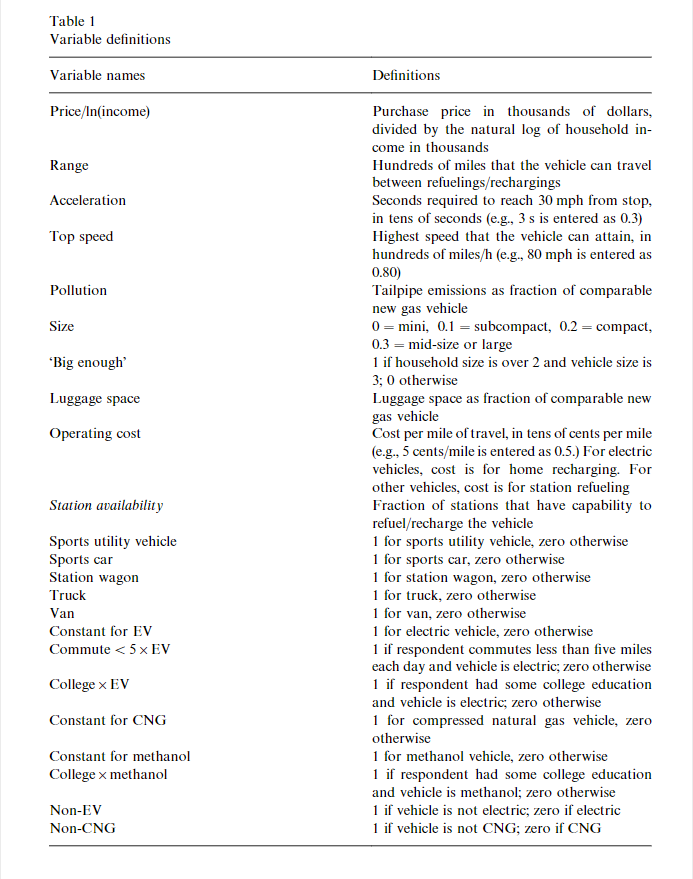

In [3]:
display.Image('brownstone_train_tab_1.PNG')

Table 1 from 'Forecasting new product penetration with flexible substitution patterns (1999), D. Brownstone, K. Train'

## Scaling variables

To be consistent with the interpretation of estimates in 'Brownstone & Train (1999)' we rescale some of the explanatory variables. Furthermore, Logit models are most stable numerically if we ensure that variables are scaled near to $\pm 1$. 

In [4]:
dat['range'] = dat['range'] / 100                  # Hundreds of miles that the vehicle can travel between fuelings
dat['top_speed'] = dat['top_speed'] / 100          # Highest speed that the vehicle can attain, in hundreds of miles per hour
dat['size'] = dat['size'] / 10                     # Scaled categorical variable for numerical purposes
dat['acceleration'] = dat['acceleration'] / 10     # Measured in tens of seconds
dat['operating_cost'] = dat['operating_cost'] / 10 # Measured in tens of cents per mile

Since, respectively, 'EV'and 'Non-EV'and 'CNG' and 'Non-CNG' are equivalent we exclude the latter and keep all the other characteristics as explanatory variables.  

In [5]:
# variables to use as explanatory variables
x_vars = list(lab.iloc[3:-4].index.values) # variable names

In [6]:
# dimensions of data
N = dat.person_id.nunique()
J = dat.j.nunique()
K = len(x_vars)

Finally, we will primarily use numpy data types and numpy functions in this notebook. Hence we store our response variable 'y' and our explanatory variables 'x' as numpy arrays.

In [7]:
# response and explanatory variables as numpy arrays
y = pd.get_dummies(dat['y'].values.reshape((N,J))[:,0]).to_numpy() # Convert y to an (N,J) array as the onehot encoding. All values are equal along axis=1 in dataframe. Becomes an (N,) array i.e. it is a vector.
x = dat[x_vars].values.reshape((N,J,K))

## Estimating the logit model

We estimate a logit model on the data using maximum likelihood. In doing this we will see our first use of the numpy function 'einsum()' which quickly and easily computes matrix products, outer products, transposes, etc. 

In [8]:
def util(Beta, x):
    '''
    This function finds the deterministic utilities u = X*Beta.
    
    Args.
        Beta: (K,) numpy array of parameters
        x: (N,J,K) matrix of covariates

    Output
        u: (N,J) matrix of deterministic utilities
    '''

    if isinstance(x, (np.ndarray)):
        u = np.einsum('njk,k->nj', x, Beta) # is the same as x @ Beta
    else:
        T = len(x.keys())
        u = {}
        for t in np.arange(T):
            u[t] = np.dot(x[t], Beta)

    return u

In [9]:
def logit_loglikehood(Beta, y, x, MAXRESCALE: bool = True):
    '''
    This function calculates the likelihood contributions of a Logit model

    Args. 
        Beta: (K,) vector of parameters 
        x: (N,J,K) matrix of covariates 
        y: (N,J) matrix of outcomes 

    Returns
        ll_i: (N,) vector of loglikelihood contributions for a Logit
    '''

    # deterministic utility 
    v = util(Beta, x)

    if isinstance(x, (np.ndarray)):
        if MAXRESCALE: 
            # subtract the row-max from each observation
            v -= v.max(axis=1, keepdims=True)  # keepdims maintains the second dimension, (N,1), so broadcasting is successful

        # denominator 
        denom = np.exp(v).sum(axis=1) # NOT keepdims! becomes (N,)

        # utility at chosen alternative for each individual i
        v_i = np.einsum('nj,nj->n', y, v) # Becomes (N,)

        # likelihood 
        ll_i = v_i - np.log(denom) # difference between two 1-dimensional arrays
    else:
        T = len(x.keys())
        ll_i = np.empty((T,))

        if MAXRESCALE:
            v = {t: v[t] - v[t].max(keepdims=True) for t in np.arange(T)}
        
        for t in np.arange(T):
            denom = np.exp(v[t]).sum()
            v_i = np.dot(y[t], v[t])
            ll_i[t] = v_i - np.log(denom)

    return ll_i


The derivative of the likelihood function $\ell_i (\theta)$ wrt. parameters in the logit model if individual $i$ chose product $j$ is given by:

$$
\nabla_\theta \ell_i(\theta) = X_j - \frac{\sum_\ell e^{ X_\ell \theta }X_\ell}{\sum_\ell e^{X_\ell \theta }}
$$

We may then consistently estimate the covariance matrix in the logit model by plugging the MLE $\hat \theta$ into the formula:

$$
\Sigma(\theta) = \left(\sum_i \nabla_\theta \ell_i(\theta)\nabla_\theta \ell_i(\theta)'\right)^{-1}
$$

In [10]:
def logit_score(theta, y, x):
    ''' 
    '''

    if isinstance(x, (np.ndarray)):
        N,J,K = x.shape

        numer_term = np.einsum('nj,njk->njk', np.exp(np.einsum('k,njk->nj', theta, x)), x)
        numer = np.einsum('j,njk->nk', np.ones((J,)), numer_term)
        denom = np.einsum('j,nj->n', np.ones((J,)), np.exp(np.einsum('k,njk->nj', theta, x)))
        score = np.einsum('nj,njk->nk', y, x - (numer / denom[:,None])[:,None,:])
    else:
        T = len(x.keys())
        score = np.empty((T, len(theta)))

        for t in np.arange(T):
            numer = np.dot(np.exp(np.dot(x[t], theta)), x[t])
            denom = np.exp(np.dot(x[t], theta)).sum()
            score[t,:] = np.dot(y[t], x[t] - np.divide(numer, denom))

    return score

In [11]:
def logit_se(theta, y, x, N):
    ''' 
    '''

    score = logit_score(theta, y, x)
    Sigma = np.einsum('nk,nm->km', score, score)
    SE = np.sqrt(np.diag(la.inv(Sigma))) / N 

    return SE

In [12]:
def logit_t_p(theta, y, x, N, theta_hypothesis = 0):
    ''' 
    '''

    if isinstance(x, (np.ndarray)):
        D,J,K = x.shape
    else:
        D = len(x.keys())

    SE = logit_se(theta, y, x, N)
    T = np.abs(theta - theta_hypothesis) / SE
    p = t.sf(T, df = D-1)

    return T,p
    

In [13]:
def q_logit(Beta, y, x):
    
    '''
    q: Criterion function, passed to estimate_logit().
    '''
    return -logit_loglikehood(Beta, y, x)

In [14]:
def q_logit_score(Beta, y, x):
    ''' 
    '''
    return -logit_score(Beta, y, x)

In [15]:
def estimate_logit(q, Beta0, y, x, N, Analytic_jac:bool = True, options = {'disp': True}, **kwargs):
    ''' 
    Takes a function and returns the minimum, given start values and 
    variables to calculate the residuals.

    Args.
        q: a function to minimize,
        Beta0 : (K+G,) array of initial guess parameters,
        y: array of observed response variables (N,),
        x: array of observed explanatory variables (N,J,K),
        options: dictionary with options for the optimizer (e.g. disp=True,
            which tells it to display information at termination.)
    
    Returns
        res: Returns a dictionary with results from the estimation.
    '''

    # The objective function is the average of q(), 
    # but Q is only a function of one variable, theta, 
    # which is what minimize() will expect
    Q = lambda Theta: np.mean(q(Theta, y, x))

    if Analytic_jac == True:
        Grad = lambda Theta: np.mean(q_logit_score(Theta, y, x), axis=0) # Finds the Jacobian of Q. Takes mean of criterion q derivatives along axis=0, i.e. the mean across individuals.
    else:
        Grad = None

    # call optimizer
    result = optimize.minimize(Q, Beta0.tolist(), options=options, jac = Grad, **kwargs)
    pars = result.x
    t,p = logit_t_p(pars, y, x, N)

    # collect output in a dict 
    res = {
        'beta': pars, # vector of estimated parameters
        'se': logit_se(pars, y, x, N),
        't': t,
        'p': p,
        'success':  result.success, # bool, whether convergence was succesful 
        'nit':      result.nit, # no. algorithm iterations 
        'nfev':     result.nfev, # no. function evaluations 
        'fun':      result.fun # function value at termination 
    }

    return res

Estimating a Logit model via maximum likelihood with an initial guess of parameters $\hat \beta^0 = 0$ yields estimated parameters $\hat \beta^{\text{logit}}$ given as...

Here '$***$', '$**$', and '$*$' indicates that we can reject the hypothesis $\beta=0$ at levels of significance $\alpha = 0.01, 0.05, 0.1$, respectively.

### We then compute the corresponding Logit choice probabilities

In [18]:
def logit_ccp(Beta, x, MAXRESCALE:bool=True):
    '''logit_ccp(): Computes the (N,J) matrix of choice probabilities from a logit model
    Args. 
        u: (N,J) matrix of  
    
    Returns
        ccp: (N,J) matrix of probabilities 
    '''
    # deterministic utility 
    v = util(Beta, x) # (N,J)

    if isinstance(x, (np.ndarray)): 
        if MAXRESCALE: 
            # subtract the row-max from each observation
            v -= v.max(axis=1, keepdims=True)  # keepdims maintains the second dimension, (N,1), so broadcasting is successful
        
        # denominator 
        denom = np.exp(v).sum(axis=1, keepdims=True) # (N,1)
        
        # Conditional choice probabilites
        ccp = np.exp(v) / denom
    else:
        T = len(x.keys())
        
        if MAXRESCALE:
            v = {t: v[t] - v[t].max(keepdims=True) for t in np.arange(T)}
        
        # denominator
        denom = {t: np.exp(v[t]).sum() for t in np.arange(T)}

        # Conditional choice probabilites
        ccp = {t: v[t] - np.log(denom[t]) for t in np.arange(T)}

    
    return ccp

Using our estimates $\hat \beta^{\text{logit}}$, the choice probabilities $\hat q_i^{logit}$ of products $\{0,1, \ldots , 5\}$ for individuals $i=0,1,\ldots , 4653$ thus becomes:

logit_q = logit_ccp(logit_beta, x)
pd.DataFrame(logit_q).rename_axis(index='individuals', columns='products')

#### Logit elasticities

The logit (semi-)elasticities of the choice probabilities $q_i = P(u| \beta)$ for individual i wrt. to the $\ell$'th characteristic are given by the formula:
$ \mathcal{E}_i= \nabla_x \ln P(u| \beta)= \left( I_J - \iota q_i'\right) \beta_\ell$
where $()'$ denotes the transpose of a matrix, $\iota=(1, \ldots, 1)'$ is the all ones vector in $\mathbb{R}^{J}$,and $I_J$ is the identity matrix in $\mathbb{R}^{J\times J}$.

Lastly we compute the implied price-to-log-income elasticities for our logit model.

In [20]:
def logit_elasticity(q, Beta, char_number):
    ''' 
    This function calculates the logit elasticities of choice probabilities wrt. a given charateristic k

    Args.
        q: a (N,J) numpy array of choice probabilities
        Beta: a (K,) numpy array of parameters
        car_number: an integer k for the index of the characteristic

    Output:
        Epsilon: a (N,J,J) matrix of logit elasticities of choice probabilities wrt. the charateristic k
    '''
    if isinstance(q, (np.ndarray)):
        assert q.ndim == 2
        assert Beta.ndim == 1

        N,J = q.shape

        iota_q = np.einsum('j,ni->nji', np.ones((J,)), q)
        Epsilon = (np.eye(J) - iota_q)*Beta[char_number]
    else:
        T = len(q.keys())
        J = {t: q[t].shape[0] for t in np.arange(T)}
        
        iota_q = {t: np.outer(np.ones(J[t]), q[t]) for t in np.arange(T)}
        Epsilon = {t: np.multiply(np.eye(J[t]) - iota_q[t], Beta[char_number]) for t in np.arange(T)}

    return Epsilon

Implemented on our datset, we thus find the elasticities as follows...

epsilon_logit = logit_elasticity(logit_q, logit_beta, 0)
pd.DataFrame(epsilon_logit[0,:,:]).rename_axis(index = 'Elasticity of products', columns='Elasticity wrt. products')

In the above example for individual $i=0$, the $j\ell$'th entry corresponds to the elasticity of the choice probability of product $j$ with respect to the price-to-log-income (i.e. the $0$'th characteristic) of product $\ell$ for $j, \ell \in \{0,1, \ldots ,  5\}$. Note that the diagonal entries are negative, indicating that all products are normal, and that the cross-elasticities (i.e. $j \neq \ell$) with respect to any product $\ell$ are equal for all $j \neq \ell$. Our example thus validates the IIA property of the logit model. 

#### Diversion Ratios for Logit

The diversion ratio to product j from product k wrt. to the $\ell$'th characteristic $-100 \cdot \frac{\partial P_j / \partial x_{k\ell}}{\partial P_k / \partial x_{k\ell}}$ for the standard logit model is given by equation:

$$
D^i = -100 \cdot \nabla_{x_\ell} P(u|\beta)(\nabla_{x_\ell} P(u|\beta) \circ I_J)^{-1} = -100 \cdot \nabla_u P(u|\beta)(\nabla_u P(u|\beta) \circ I_J)^{-1}
$$

Where '$\circ$' is the elementwise product of matrices and $\nabla_{x_\ell} P(u|\beta) = \beta_\ell(\mathrm{diag}(q) - qq')$ is the usual derivative of Logit choice probailities wrt. the $\ell$'th characteristic.

In [23]:
def logit_diversion_ratio(q, Beta):
    '''
    This function calculates the logit diversion ratios of choice probabilities wrt. a given charateristic k

    Args.
        q: a (N,J) numpy array of choice probabilities
        Beta: a (K,) numpy array of parameters
        car_number: an integer k for the index of the characteristic

    Output:
        DR: a (N,J,J) matrix of logit diversion ratios of choice probabilities wrt. the charateristic k
    '''

    if isinstance(q, (np.ndarray)):
        assert q.ndim == 2
        assert Beta.ndim == 1

        N,J = q.shape
        diag_q = q[:,:,None] * np.eye(J,J)[None, :, :]
        qqT = np.einsum('nj,nk->njk', q, q)
        Grad = diag_q - qqT
        diag_Grad_mat = Grad * np.eye(J,J)[None, :, :]
        diag_Grad_vec = np.einsum('njk,k->nj', diag_Grad_mat, np.ones((J,)))
        DR = -100 * np.einsum('njk,nj->njk', Grad, 1./diag_Grad_vec)
    else:
        T = len(q.keys())
        J = {t: q[t].shape[0] for t in np.arange(T)}

        diag_q = {t: np.multiply(np.eye(J[t]), q[t]) for t in np.arange(T)}
        qqT = {t: np.outer(q[t], q[t]) for t in np.arange(T)}
        Grad = {t: diag_q[t] - qqT[t] for t in np.arange(T)}
        diag_Grad = {t: np.multiply(Grad[t], np.eye(J[t])) for t in np.arange(T)}
        DR = {t: np.multiply(-100, np.dot(Grad[t], la.inv(diag_Grad[t]))) for t in np.arange(T)}

    return DR
    


DR_logit_hat = logit_diversion_ratio(logit_q, logit_beta)
pd.DataFrame(DR_logit_hat[0,:,:]).rename_axis(index = 'Div. ratio of products', columns='Div. ratio wrt. products')

own_DR_logit = {j : (DR_logit_hat.reshape((N, J**2))[:,j]).flatten() for j in np.arange(J**2)} # Finds j'th entry in each of the elasticity matrices of individuals i.  

j_pairs = iter.product(np.arange(J), np.arange(J))
num_bins = 25

fig, axes = plt.subplots(J, J)

for p, j in zip(j_pairs, np.arange(J**2)):
    axes[p].hist(own_DR_logit[j], num_bins)
    axes[p].vlines(0, 0, 1500, 'red', 'dotted')
    axes[p].get_xaxis().set_visible(False)
    axes[p].get_yaxis().set_visible(False)

fig.suptitle('Logit price-to-log-income diversion ratios')
plt.show()